In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PyCO2SYS as pyco2
import string
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.optimize import least_squares
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../../compilation/data/in_situ_rates_compiled_allvar_uncertainty.csv")

In [2]:
# add uncertainty
df['u_TA_CDisk4'] = 4 # n19
df['u_pH_CDisk4'] = 0.001 # n19
df['u_PO4_CDisk4'] = 0.03 # n19, their uncertainty but 'my' nutrient data
df['u_SiOH4_CDisk4'] = 1.5 # n19, their uncertainty but 'my' nutrient data
df['u_Temp_CDisk4'] = df["Temp_CDisk4"]*0.02 # based on Table 3, GLODAPv2.2022 data
df['u_Sal_CDisk4'] = 0.005 # based on Table 3, GLODAPv2.2022 data


# re-calculate Omega_calc for CDisk so I have the uncertainty
cdisk = pyco2.sys(par1=df["TA_CDisk4"], 
                    par2=df["pH_CDisk4_T25"], 
                    par1_type = 1, par2_type=3, 
                    salinity=df["Salinity_CDisk4"], 
                    temperature_out=df["Temp_CDisk4"], 
                    pressure_out=df["Pressure"],
                    total_silicate=df["SiOH4_cb"], 
                    total_phosphate=df["PO4_cb"],
                  uncertainty_into=["saturation_calcite_out", "saturation_aragonite_out"],
                  uncertainty_from={
                      "par1": df['u_TA_CDisk4'],
                      "par2": df['u_pH_CDisk4'],
                      "salinity": df['u_Sal_CDisk4'] ,                   
                      "temperature": df['u_Temp_CDisk4'],
                      "total_silicate": df['u_SiOH4_CDisk4'],
                      "total_phosphate": df['u_PO4_CDisk4']})


df["pH_insitu_CDisk4"] = cdisk['pH_out']

# calculated myself
df["Oca_CDisk4_calc13_calc"] = cdisk['saturation_calcite_out']
df["Oar_CDisk4_calc13_calc"] = cdisk['saturation_aragonite_out']
df["u_Oca_CDisk4_calc13_calc"] = cdisk['u_saturation_calcite_out']
df["u_Oar_CDisk4_calc13_calc"] = cdisk['u_saturation_aragonite_out']


df["Omega_CDisk4_calc13_calc"] = np.where(df["Material"].eq("Aragonite"), 
                                             df["Oar_CDisk4_calc13_calc"], df["Oca_CDisk4_calc13_calc"])
df["u_Omega_CDisk4_calc13_calc"] = np.where(df["Material"].eq("Aragonite"), 
                                             df["u_Oar_CDisk4_calc13_calc"], df["u_Oca_CDisk4_calc13_calc"])


# make new column for Omega I use (estimated for all except the CDisK-IV ones)
df["Omega_use"] = np.where(df["Omega_CDisk4_calc13"].isna(), 
                                             df["Omega_calc23"], df["Omega_CDisk4_calc13"])
df["u_Omega_use"] = np.where(df["u_Omega_CDisk4_calc13_calc"].isna(), 
                                             df["u_Omega_calc23"], df["u_Omega_CDisk4_calc13_calc"])

## Make subsets (biogenic, mass normalised)

In [3]:
df_set = df[(df['Rate_mass'].isna() == False) & (df["Omega_use"] < 0.999) 
            & (df["Biogenic"] == True) & (df['Rate_mass'] > 0)]

In [4]:
def linreg(d): # dataframe
    x = np.log10(1-d["Omega_use"])
    y = np.log10(d["Rate_mass"])
    x,y = np.array(x).reshape((-1,1)), np.array(y)
    model = LinearRegression().fit(x, y) 
    return model.coef_[0], model.intercept_ 
    
def plot_rate(o_crit, color):
    label = '$\Omega_{crit} = $' + f'{o_crit:.2f}'
    print(o_crit)
    
    # make two dissolution regimes
    df_slow = df_set[df_set["Omega_use"] >= o_crit]
    df_fast = df_set[df_set["Omega_use"] < o_crit]
    
    x_slow = np.arange(o_crit,1,0.001)
    x_fast = np.arange(0.4,o_crit+0.001,0.001)
    
    # slow
    n_slow, k_slow = linreg(df_slow)
    print('slow:', round(n_slow,3), round(10**(k_slow),3) )    
    plt.plot(x_slow, 10**(k_slow)*(1-x_slow)**n_slow, color=color, label=label)
    
    # fast
    n_fast, k_fast = linreg(df_fast)
    print('fast:', round(n_fast,3), round(10**(k_fast),3) )    
    plt.plot(x_fast, 10**(k_fast)*(1-x_fast)**n_fast, color=color)
    

## Figure 14

one regime: 1.2589429576257005 -0.07269008701377588
0.85
slow: 0.538 0.157
fast: 1.915 1.95
0.8
slow: 0.756 0.294
fast: 2.293 2.953
0.75
slow: 0.838 0.356
fast: 2.757 4.661


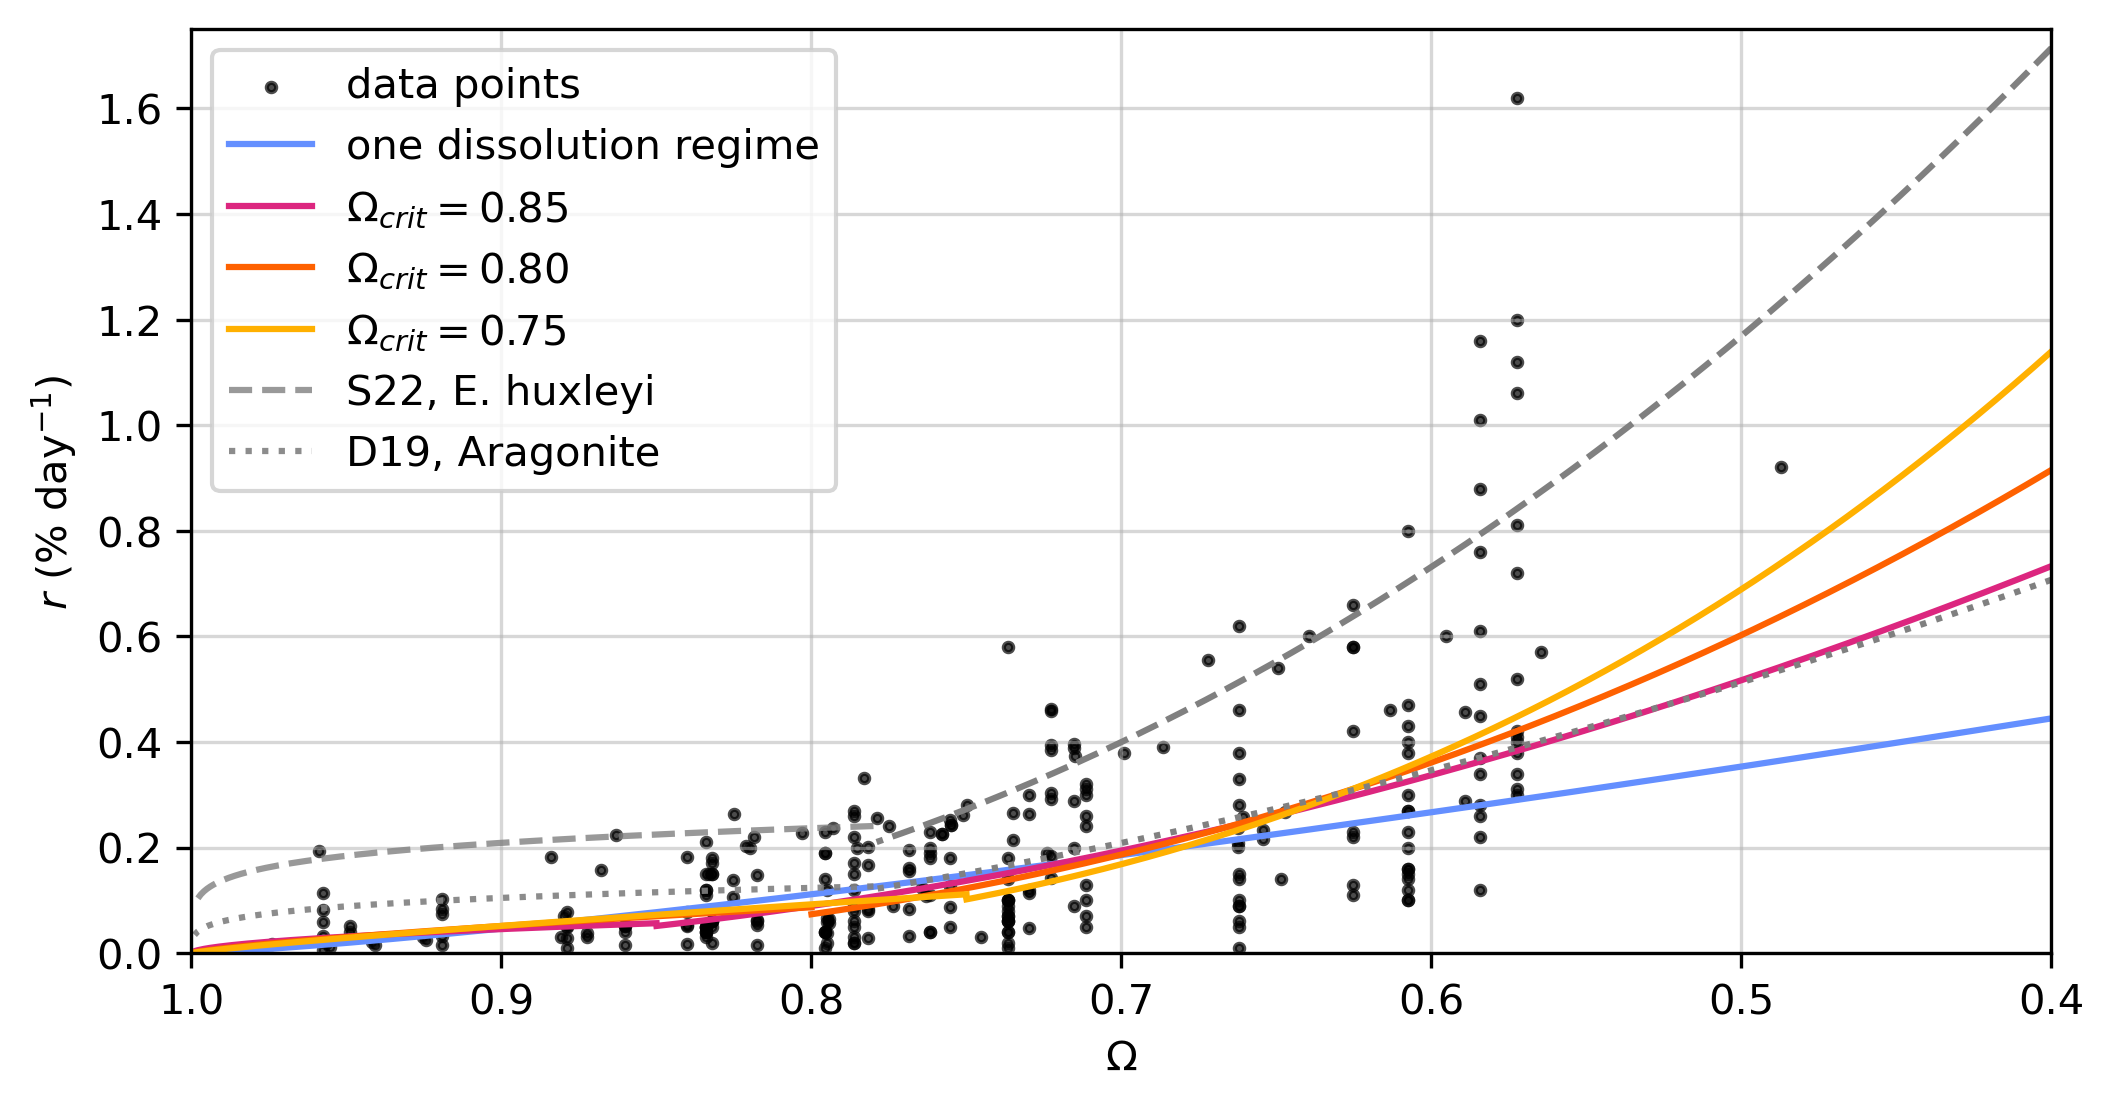

In [5]:
plt.figure(figsize=(8,4), dpi=300)

plt.scatter(df_set['Omega_use'],df_set['Rate_mass'], color="black", s=5, label='data points', alpha=0.7)


# linear
color = '#648FFF'
x_all = np.arange(0.4,1,0.001)
n_all, k_all = linreg(df_set)
print('one regime:', n_all, k_all )    
plt.plot(x_all, 10**(k_all)*(1-x_all)**n_all, color='#648FFF', label='one dissolution regime')

# omega_crit
plot_rate(0.85, '#DC267F')
plot_rate(0.80, '#FE6100')
plot_rate(0.75, '#FFB000')


# m82
#n1, k1, n2, k2 = [ 0.41563626, -1.00281176,  4.96994058,  2.0894692 ]
#x_range1 = np.arange(0.79,1,0.001)
#x_range2 = np.arange(0.4,0.79,0.001)
#plt.plot(x_range1, 10**(k1)*(1-x_range1)**n1, color='green', label='m82, Size L', 
#         linestyle='--', alpha=0.6)
#plt.plot(x_range2, 10**(k2)*(1-x_range2)**n2, color='green', linestyle='--', alpha=0.8)

#n1, k1, n2, k2 = [-0.31691552, -1.36913667,  1.71653539,0.3842296 ]
#x_range1 = np.arange(0.86,1,0.001)
#x_range2 = np.arange(0.4,0.86,0.001)
#plt.plot(x_range1, 10**(k1)*(1-x_range1)**n1, color='green', label='m82, Size XS', 
#         linestyle='dotted', alpha=0.6)
#plt.plot(x_range2, 10**(k2)*(1-x_range2)**n2, color='green', linestyle='dotted', alpha=0.8)



# s22
n1, k1, n2, k2 = [0.18, -2.5,  2.1, -1.3]
x_range1 = np.arange(0.78,1,0.001)
x_range2 = np.arange(0.4,0.78,0.001)
plt.plot(x_range1, 10**(k1)*100*(1-x_range1)**n1, color='grey', label='S22, E. huxleyi', 
         linestyle='--', alpha=0.8)
plt.plot(x_range2, 10**(k2)*100*(1-x_range2)**n2, color='grey', linestyle='--', alpha=1)

n1, k1, n2, k2 = [0.24, -2.74, 1.76, -1.76]
x_range1 = np.arange(0.78,1,0.001)
x_range2 = np.arange(0.4,0.78,0.001)
plt.plot(x_range1, 10**(k1)*100*(1-x_range1)**n1, color='grey', label='D19, Aragonite', 
         linestyle='dotted', alpha=0.9)
plt.plot(x_range2, 10**(k2)*100*(1-x_range2)**n2, color='grey', linestyle='dotted', alpha=1)


plt.grid(alpha=0.5)
plt.xlim(0.4,1)
plt.ylim(0,1.75)
plt.gca().invert_xaxis()
plt.xlabel('$\Omega$')
plt.ylabel('$r$ (% day$^{-1}$)')
plt.legend()
#plt.yscale('log')
plt.show()

## Dissolution rates with different $Ω_\text{crit}$

In [6]:
def rate(omega, o_crit):
    df_fast = df_set[df_set["Omega_use"] < o_crit]
    n_fast, k_fast = linreg(df_fast)
    rate_fast = 10**(k_fast)*(1-omega)**n_fast
    return rate_fast

In [7]:
omega=0.4
print('at Ω = 0.4 (aragonite at seafloor):')
print('Ω_crit = 0.75:   ', round(rate(omega,0.75),4))
print('Ω_crit = 0.80:   ', round(rate(omega,0.8),4))
print('Ω_crit = 0.85:   ', round(rate(omega,0.85),4))
print()
print('just one dissolution regime:')
n_all, k_all = linreg(df_set)
rate_all = 10**(k_all)*(1-omega)**n_all
print(round(rate_all,4))

at Ω = 0.4 (aragonite at seafloor):
Ω_crit = 0.75:    1.1396
Ω_crit = 0.80:    0.9152
Ω_crit = 0.85:    0.7331

just one dissolution regime:
0.4446


In [30]:
print((0.9152-1.1396)/1.1396)

-0.19691119691119685


In [8]:
print((1.1396-0.7331)/0.7331)
print((1.1396-0.9152)/0.9152)
print((0.915-0.4446)/0.4446)

0.5544946119219751
0.24519230769230763
1.058029689608637


In [9]:
omega=0.6
print('at Ω = 0.6 (calcite at seafloor):')
print('Ω_crit = 0.75:   ', round(rate(omega,0.75),4))
print('Ω_crit = 0.80:   ', round(rate(omega,0.8),4))
print('Ω_crit = 0.85:   ', round(rate(omega,0.85),4))
print()
print('just one dissolution regime:')
n_all, k_all = linreg(df_set)
rate_all = 10**(k_all)*(1-omega)**n_all
print(round(rate_all,4))

at Ω = 0.6 (calcite at seafloor):
Ω_crit = 0.75:    0.3726
Ω_crit = 0.80:    0.3612
Ω_crit = 0.85:    0.3372

just one dissolution regime:
0.2669


In [10]:
print((0.3612-0.3726)/0.3726)

-0.030595813204508767


In [11]:
print((0.3726-0.3372)/0.3372)
print((0.3726-0.3612)/0.3612)
print((0.3612-0.2669)/0.2669)

0.10498220640569392
0.031561461794019835
0.3533158486324466
